In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_landmarks(sample):
    """Plots landmarks for face, left hand, and right hand from a feature vector."""
    fig, ax = plt.subplots(figsize=(5, 5))

    # Split the sample into parts
    face_landmarks = sample[:42].reshape(-1, 2)
    left_hand_landmarks = sample[42:84].reshape(-1, 2)
    right_hand_landmarks = sample[84:126].reshape(-1, 2)

    # Plot each set of landmarks
    if np.any(face_landmarks):
        ax.scatter(face_landmarks[:, 0], -face_landmarks[:, 1], label="Face", c="blue")

    if np.any(left_hand_landmarks):
        ax.scatter(left_hand_landmarks[:, 0], -left_hand_landmarks[:, 1], label="Left Hand", c="red")

    if np.any(right_hand_landmarks):
        ax.scatter(right_hand_landmarks[:, 0], -right_hand_landmarks[:, 1], label="Right Hand", c="green")

    ax.legend()
    ax.set_title("Landmark Visualization")
    plt.show()

# Load any .npy file
file_path = "/content/drive/MyDrive/face_emotion_based_music_rec/data/Thumbsup.npy"
data = np.load(file_path)

# Visualize first sample
visualize_landmarks(data[0])


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/face_emotion_based_music_rec/data/Thumbsup.npy'

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_image(sample, image_size=(480, 640)):
    """Reconstructs an image using landmarks and displays it."""
    canvas = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 255  # White background

    def draw_landmarks(landmarks, color):
        """Draws the landmarks on the canvas."""
        for x, y in landmarks:
            x = int((x + 1) * image_size[1] / 2)  # Scale X to image width
            y = int((y + 1) * image_size[0] / 2)  # Scale Y to image height
            cv2.circle(canvas, (x, y), 5, color, -1)

    # Extract & draw landmarks
    face_landmarks = sample[:42].reshape(-1, 2)
    left_hand_landmarks = sample[42:84].reshape(-1, 2)
    right_hand_landmarks = sample[84:126].reshape(-1, 2)

    draw_landmarks(face_landmarks, (255, 0, 0))  # Blue for face
    draw_landmarks(left_hand_landmarks, (0, 255, 0))  # Green for left hand
    draw_landmarks(right_hand_landmarks, (0, 0, 255))  # Red for right hand

    # Convert BGR to RGB for displaying
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Load the .npy file
file_path = "/content/drive/MyDrive/face_emotion_based_music_rec/data/happy.npy"
data = np.load(file_path)

# Reconstruct and show the first sample
reconstruct_image(data[0])


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/face_emotion_based_music_rec/data/happy.npy'

In [ ]:

def load_data(directory):
    npy_files = [file_name for file_name in os.listdir(directory) if file_name.endswith(".npy") and file_name != "labels.npy"]
    if not npy_files:
        print("\nNo suitable files found in the directory.")
        return None, None
    X, y = None, None
    labels = []
    for idx, file_name in enumerate(npy_files):
        print(f"Processing file {idx+1}/{len(npy_files)}: {file_name}")
        try:
            data = np.load(os.path.join(directory, file_name))
            if X is None:
                X = data
                y = np.full((data.shape[0], 1), idx)
            else:
                X = np.concatenate((X, data))
                y = np.concatenate((y, np.full((data.shape[0], 1), idx)))
            labels.append(file_name.split('.')[0])
        except Exception as e:
            print(f"Error loading file {file_name}: {e}")
    return X, y, labels

def preprocess_data(X, y):
    # Converting Integer to binary class matrix
    y = tf.keras.utils.to_categorical(y)
    # Shuffling data to avoid clustering
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    y = y[idx]
    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc'])
    return model

def train_model(model, X_train, y_train, epochs=50):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, callbacks=[early_stop], verbose=1)

def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

def save_model(model, labels):
    model.save("model.h5")
    np.save("labels.npy", np.array(labels))

def main():
    directory = "/content/drive/MyDrive/face_emotion_based_music_rec/data/"  # Change this to your data directory
    X, y, labels = load_data(directory)
    if X is None:
        return
    X_train, X_test, y_train, y_test = preprocess_data(X, y)
    model = build_model(X_train.shape[1:], len(labels))
    train_model(model, X_train, y_train, epochs=80)  # Increase the number of epochs
    evaluate_model(model, X_test, y_test)
    save_model(model, labels)

if __name__ == "__main__":
    main()


Processing file 1/9: Thumbsup.npy
Processing file 2/9: angry.npy
Processing file 3/9: neutral.npy
Processing file 4/9: rock.npy
Processing file 5/9: happy.npy
Processing file 6/9: hello.npy
Processing file 7/9: No.npy
Processing file 8/9: surprise.npy
Processing file 9/9: sad.npy
Epoch 1/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - acc: 0.1120 - loss: 2.1989 - val_acc: 0.0972 - val_loss: 2.1702
Epoch 2/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.1819 - loss: 2.1651 - val_acc: 0.2361 - val_loss: 2.1415
Epoch 3/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.1808 - loss: 2.1587 - val_acc: 0.4028 - val_loss: 2.1070
Epoch 4/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2999 - loss: 2.1055 - val_acc: 0.5556 - val_loss: 2.0427
Epoch 5/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2896 - loss: 2.0615 - val_acc: 0.5694 - val_loss: 1.9656
Epoch 6/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2897 - loss: 2.0384 - val_acc: 0.5694 - val_loss: 1.8866
Epoch 7/80
21/21 ━━━━

Test Loss: 0.4358
Test Accuracy: 88.33%


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test, labels):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation='vertical')

    # Model Evaluation
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return loss, accuracy, cm


In [7]:
import matplotlib.pyplot as plt

def train_model(model, X_train, y_train, epochs=50):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, callbacks=[early_stop], verbose=1)

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Train Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.show()

    return history


In [8]:
def main():
    directory = "/content/drive/MyDrive/face_emotion_based_music_rec/data/"
    X, y, labels = load_data(directory)

    if X is None:
        return

    X_train, X_test, y_train, y_test = preprocess_data(X, y)
    model = build_model(X_train.shape[1:], len(labels))

    history = train_model(model, X_train, y_train, epochs=80)

    loss, accuracy, cm = evaluate_model(model, X_test, y_test, labels)

    save_model(model, labels)


Processing file 1/9: Thumbsup.npy
Processing file 2/9: angry.npy
Processing file 3/9: neutral.npy
Processing file 4/9: rock.npy
Processing file 5/9: happy.npy
Processing file 6/9: hello.npy
Processing file 7/9: No.npy
Processing file 8/9: surprise.npy
Processing file 9/9: sad.npy
Epoch 1/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - acc: 0.1318 - loss: 2.1975 - val_acc: 0.3611 - val_loss: 2.1543
Epoch 2/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - acc: 0.1314 - loss: 2.1745 - val_acc: 0.3889 - val_loss: 2.1226
Epoch 3/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.1879 - loss: 2.1429 - val_acc: 0.2917 - val_loss: 2.0855
Epoch 4/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.2480 - loss: 2.1110 - val_acc: 0.5833 - val_loss: 2.0280
Epoch 5/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - acc: 0.2618 - loss: 2.0464 - val_acc: 0.4306 - val_loss: 1.9527
Epoch 6/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - acc: 0.2685 - loss: 2.0014 - val_acc: 0.3889 - val_loss: 1.8706
Epoch 7/80
21/21 

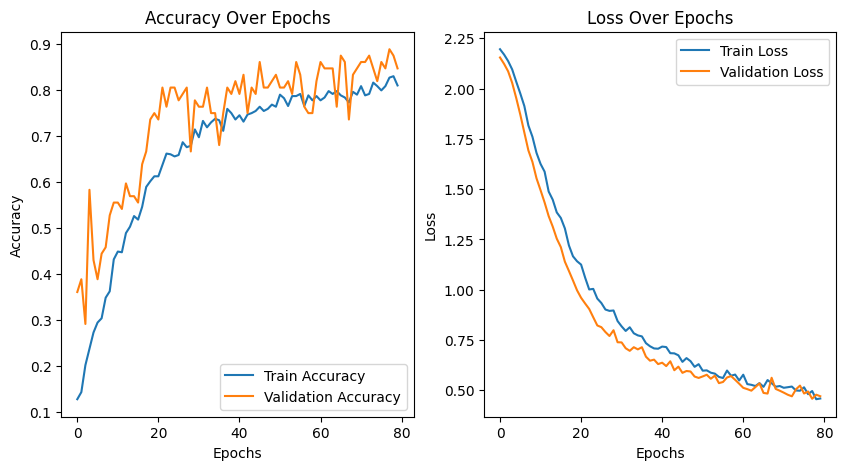

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Classification Report:
              precision    recall  f1-score   support

    Thumbsup       1.00      0.76      0.87        17
       angry       1.00      0.84      0.91        19
     neutral       0.88      0.56      0.68        27
        rock       0.70      1.00      0.82        16
       happy       0.94      0.94      0.94        18
       hello       0.87      0.87      0.87        23
          No       1.00      0.84      0.91        19
    surprise       0.96      0.93      0.94        27
         sad       0.46      0.93      0.62        14

    accuracy                           0.84       180
   macro avg       0.87      0.85      0.84       180
weighted avg       0.89      0.84      0.85       180

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8423 - loss: 0.4377



Test Loss: 0.4534
Test Accuracy: 83.89%


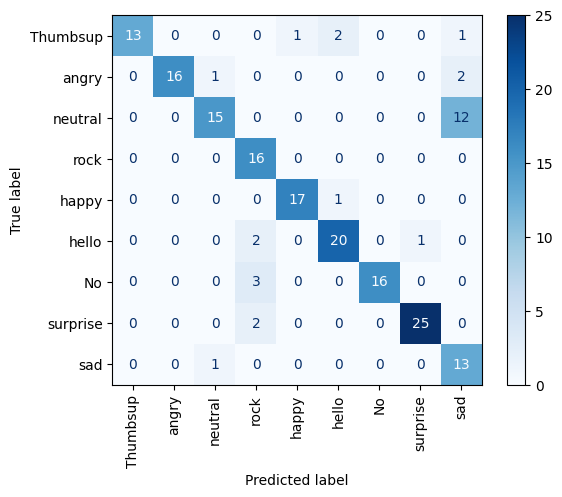

In [ ]:
main()

In [ ]:
pip install mediapipe --upgrade

In [ ]:
!pip show mediapipe

Name: mediapipe
Version: 0.10.21
Summary: MediaPipe is the simplest way for researchers and developers to build world-class ML solutions and applications for mobile, edge, cloud and the web.
Home-page: https://github.com/google/mediapipe
Author: The MediaPipe Authors
Author-email: mediapipe@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, attrs, flatbuffers, jax, jaxlib, matplotlib, numpy, opencv-contrib-python, protobuf, sentencepiece, sounddevice
Required-by: 


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [9]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Use Colab's OpenCV display function

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

def process_landmarks(landmarks, reference_landmark=None):
    if landmarks:
        lst = []
        for lm in landmarks.landmark:
            lst.append(lm.x - reference_landmark.x if reference_landmark else lm.x)
            lst.append(lm.y - reference_landmark.y if reference_landmark else lm.y)
        return lst
    else:
        return [0.0] * 1020  # Adjust length to match model input size

# Load Model
model = tf.keras.models.load_model("/content/model.h5")
label = np.load("/content/labels.npy")

# Initialize Mediapipe
holistic = mp.solutions.holistic
hands = mp.solutions.hands
hol = holistic.Holistic()
drawing = mp.solutions.drawing_utils

# Load the image
image_path = "/content/Screenshot 2025-03-20 121622.jpg"  # Replace with your uploaded image filename
image = cv2.imread(image_path)
plt.imshow(image)
plt.show()

if image is None:
    print("Error: Image not found. Make sure the file is uploaded and the path is correct.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    res = hol.process(image_rgb)

    # Process landmarks
    face_landmarks = process_landmarks(res.face_landmarks, res.face_landmarks.landmark[1]) if res.face_landmarks else [0.0] * 42
    left_hand_landmarks = process_landmarks(res.left_hand_landmarks, res.left_hand_landmarks.landmark[8]) if res.left_hand_landmarks else [0.0] * 42
    right_hand_landmarks = process_landmarks(res.right_hand_landmarks, res.right_hand_landmarks.landmark[8]) if res.right_hand_landmarks else [0.0] * 42

    lst = np.array(face_landmarks + left_hand_landmarks + right_hand_landmarks)

    # Ensure correct shape
    total_length = len(lst)
    repetitions = int(1020 / total_length)
    lst = np.tile(lst, (repetitions, 1))
    lst = lst.reshape(1, -1).astype(np.float32)

    pred = label[np.argmax(model.predict(lst))]
    print(f"Predicted Label: {pred}")

    cv2.putText(image, pred, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Draw landmarks
    drawing.draw_landmarks(image, res.face_landmarks, holistic.FACEMESH_TESSELATION)
    drawing.draw_landmarks(image, res.left_hand_landmarks, hands.HAND_CONNECTIONS if res.left_hand_landmarks else None)
    drawing.draw_landmarks(image, res.right_hand_landmarks, hands.HAND_CONNECTIONS if res.right_hand_landmarks else None)

    # Show image in Colab
    cv2_imshow(image)


ModuleNotFoundError: No module named 'mediapipe'

In [10]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Use Colab's OpenCV display function

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

def process_landmarks(landmarks, reference_landmark=None):
    if landmarks:
        lst = []
        for lm in landmarks.landmark:
            lst.append(lm.x - reference_landmark.x if reference_landmark else lm.x)
            lst.append(lm.y - reference_landmark.y if reference_landmark else lm.y)
        return lst
    else:
        return [0.0] * 1020  # Adjust length to match model input size

# Load Model
model = tf.keras.models.load_model("/content/model.h5")
label = np.load("/content/labels.npy")

# Initialize Mediapipe
holistic = mp.solutions.holistic
hands = mp.solutions.hands
hol = holistic.Holistic()
drawing = mp.solutions.drawing_utils

# Load the image
image_path = "/content/Screenshot 2025-03-20 121622.jpg"  # Replace with your uploaded image filename
image = cv2.imread(image_path)
plt.imshow(image,cmap = "gray")
plt.show()

if image is None:
    print("Error: Image not found. Make sure the file is uploaded and the path is correct.")
else:
    print("Sfffffffffffffffffffffffffffffffffffff")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    res = hol.process(image_rgb)

    # Process landmarks
    face_landmarks = process_landmarks(res.face_landmarks, res.face_landmarks.landmark[1]) if res.face_landmarks else [0.0] * 42
    left_hand_landmarks = process_landmarks(res.left_hand_landmarks, res.left_hand_landmarks.landmark[8]) if res.left_hand_landmarks else [0.0] * 42
    right_hand_landmarks = process_landmarks(res.right_hand_landmarks, res.right_hand_landmarks.landmark[8]) if res.right_hand_landmarks else [0.0] * 42

    lst = np.array(face_landmarks + left_hand_landmarks + right_hand_landmarks)

    # Ensure correct shape
    total_length = len(lst)
    repetitions = int(1020 / total_length)
    lst = np.tile(lst, (repetitions, 1))
    lst = lst.reshape(1, -1).astype(np.float32)

    pred = label[np.argmax(model.predict(lst))]
    print(f"Predicted Label: {pred}")

    cv2.putText(image, pred, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Draw landmarks
    drawing.draw_landmarks(image, res.face_landmarks, holistic.FACEMESH_TESSELATION)
    drawing.draw_landmarks(image, res.left_hand_landmarks, hands.HAND_CONNECTIONS if res.left_hand_landmarks else None)
    drawing.draw_landmarks(image, res.right_hand_landmarks, hands.HAND_CONNECTIONS if res.right_hand_landmarks else None)

    # Show image in Colab
    cv2_imshow(image)


ModuleNotFoundError: No module named 'mediapipe'

In [11]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Use Colab's OpenCV display function

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

def process_landmarks(landmarks, reference_landmark=None):
    if landmarks:
        lst = []
        for lm in landmarks.landmark:
            lst.append(lm.x - reference_landmark.x if reference_landmark else lm.x)
            lst.append(lm.y - reference_landmark.y if reference_landmark else lm.y)
        return lst
    else:
        return [0.0] * 1020  # Adjust length to match model input size

# Load Model
model = tf.keras.models.load_model("/content/model.h5")
label = np.load("/content/labels.npy")

# Initialize Mediapipe
holistic = mp.solutions.holistic
hands = mp.solutions.hands
hol = holistic.Holistic()
drawing = mp.solutions.drawing_utils

# Load the image
image_path = "/content/Screenshot 2025-03-20 121622.jpg"  # Replace with your uploaded image filename
image = cv2.imread(image_path)
plt.imshow(image,cmap = "gray")
plt.show()

if image is None:
    print("Error: Image not found. Make sure the file is uploaded and the path is correct.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    res = hol.process(image_rgb)

    # Process landmarks
    face_landmarks = process_landmarks(res.face_landmarks, res.face_landmarks.landmark[1]) if res.face_landmarks else [0.0] * 42
    left_hand_landmarks = process_landmarks(res.left_hand_landmarks, res.left_hand_landmarks.landmark[8]) if res.left_hand_landmarks else [0.0] * 42
    right_hand_landmarks = process_landmarks(res.right_hand_landmarks, res.right_hand_landmarks.landmark[8]) if res.right_hand_landmarks else [0.0] * 42

    lst = np.array(face_landmarks + left_hand_landmarks + right_hand_landmarks)

    # Ensure correct shape
    total_length = len(lst)
    repetitions = int(1020 / total_length)
    lst = np.tile(lst, (repetitions, 1))
    lst = lst.reshape(1, -1).astype(np.float32)

    pred = label[np.argmax(model.predict(lst))]
    print(f"Predicted Label: {pred}")

    cv2.putText(image, pred, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Draw landmarks
    drawing.draw_landmarks(image, res.face_landmarks, holistic.FACEMESH_TESSELATION)
    drawing.draw_landmarks(image, res.left_hand_landmarks, hands.HAND_CONNECTIONS if res.left_hand_landmarks else None)
    drawing.draw_landmarks(image, res.right_hand_landmarks, hands.HAND_CONNECTIONS if res.right_hand_landmarks else None)

    # Show image in Colab
    cv2_imshow(image)


ModuleNotFoundError: No module named 'mediapipe'

In [ ]:
!cp /content/model.h5 /content/drive/MyDrive/face_emotion_based_music_rec/

cp: cannot stat '/content/model.h5': No such file or directory


In [ ]:
!cp /content/labels.npy /content/drive/MyDrive/face_emotion_based_music_rec/


cp: cannot stat '/content/labels.npy': No such file or directory


In [ ]:
pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.13
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.5
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.7.1
arviz                              0.20.0
astropy                            7.0.1
astropy-iers-data                  0.2025.3.10.0.29.26
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.3.0
audioread          